# JPEG Decoding
## An in-depth look at the JPEG File Interchange Format with Python3
#### Skyler Rankin, 2019

### Introduction
This notebook explores the mechanisms and algorithms at play behind one of the most widely used image file formats. By parsing the file byte by byte, and using a specification reference, we can interpret all of the information stored in the file, and generate the corresponding image without a pre-built image viewer. The primary reference used will be the [International Telecommunication Union Recommendation T.81](https://www.w3.org/Graphics/JPEG/itu-t81.pdf).

### Table of Contents
#### [Section 1](#1) | JPEG Structure
#### [Section 2](#2) | Decoder Architecture
#### [Section 3](#3) | Parsing Segments: Part 1
#### [Section 4](#4) | Huffman Encoding
#### [Section 5](#5) | Parsing Segments: Part 2
#### [Section 6](#6) | Scan Data
#### [Section 7](#7) | Notes

## Section 1: JPEG Structure<a name="1"></a>
First, we must select an image to work with. I have included a small default image with this repository for testing. We can display the image by doing the following:

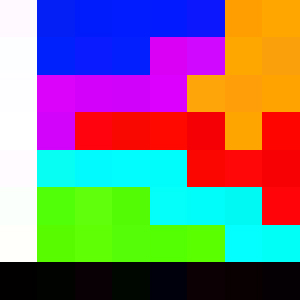

In [13]:
from IPython.display import Image
image_filename = "images\colors.jpg"
Image("images\colors_large.jpg", width=200)

### 1.1 -  Raw Information
Like any digitally stored file, a JPEG image at its simplest digital form is a chunk of binary data. We can see this by printing out the contents of the file directly. This could be done in binary, but hex is far easier to read. Hex values are base-16 numbers, using values `0-9` and `A-F`. Windows PowerShell has the command `fhx`, and Linux has the command `hexdump`, which can both print out the contents of a file as hex. We see the results below: 
<img src="images/1.1.jpg">

The left most column is showing byte numbers as hex values; the first line starts with byte `0...0` which is also `0` as decimal, the second line starts with byte `0...10` or `16` as a decimal, so we can see each row contains 16 bytes from the image data. The center column shows the bytes that are being read from the file, and the right most column shows TODO.
This is the data, the entire contents of some image. It is up to the decoder to make sense of all these values and produce an image that actually has a visual.

### 1.2 - Markers
The structure of a JPEG file relies upon a system of **markers**. These are specific 2-byte sequences that are reserved for a specific purpose, so that when you see one in the file, you can be sure of its meaning. For convenience, I will represent these byte sequences as hex values preceeded by `0x`, meaning the decimal number `78` is represented as `1001110` as binary in the image file, but is written as `0x4E` in hex for our purposes. In the JPEG File Format, all markers are preceeded by `0xFF`, which makes the marker two bytes in total.
The first markers to look for are the **SOI** and **EOI** markers. These signify **start of image** and **end of image** respectively.

Marker | Value
--- | --- 
SOI | 0xFFD8
EOI | 0xFFD9

We can be sure that no important information for the image will come before the `SOI` marker, and no information will come after the `EOI`. The information between these markers can be referred to as a segment. A common idea for structuring segments is using a **header**. A header is a small sequence of bytes at the beginning of a segment that describe what that segment contains. The specifics for the headers are dependent on the marker type, but we will see many of these headers as we parse the image file. An example of this is the `SOF0` marker, which denotes the **start of frame 0**. This segment uses the marker `0xC0` and contains information regarding the image data. The specifics of extracting information from headers will come in the next section.

Before we can parse these headers and segments, it helps to define a function to convert the bytes read from the file as Python `byte` objects into pure integers. This makes storing and manipulating their values simpler later on. I've written the function `hti`, "Hex To Integer", to do just that: takes in a byte and returns the integer representation, followed by a test to show that it is working.

In [14]:
def hti(h):
    return int.from_bytes(h, byteorder='big')

print("Hex value 0xD8 converted with function: ",hti(b'\xD8'))
print("Actual integer value: ",16*13+8)

Hex value 0xD8 converted with function:  216
Actual integer value:  216


Next we make a dictionary of all the markers that will be important for decoding the image. The first six are manually typed, and the final 16 are just a sequence of *APP0* through *APP16*. The meaning of all of these markers will becomes clear as we parse them from the file.

In [15]:
markers = {
        0xFFD8: "SOI",
        0xFFC0: "SOF0",
        0xFFC4: "DHT",
        0xFFDB: "DQT",
        0xFFDA: "SOS",
        0xFFD9: "EOI",
    }
for i in range(17):
    markers[(0xFFE0+i)] = "APP{}".format(i)
print(markers)

{65496: 'SOI', 65472: 'SOF0', 65476: 'DHT', 65499: 'DQT', 65498: 'SOS', 65497: 'EOI', 65504: 'APP0', 65505: 'APP1', 65506: 'APP2', 65507: 'APP3', 65508: 'APP4', 65509: 'APP5', 65510: 'APP6', 65511: 'APP7', 65512: 'APP8', 65513: 'APP9', 65514: 'APP10', 65515: 'APP11', 65516: 'APP12', 65517: 'APP13', 65518: 'APP14', 65519: 'APP15', 65520: 'APP16'}


### 1.3 - Image Structure Overview

With all the markers defined, we can take a pass over the image and see what markers appear. To visualize this, I will draw a graph that checks when a marker is found, and then records the number of bytes until the next marker. This way, we can see how large each segment is, since each segment is started with some marker.

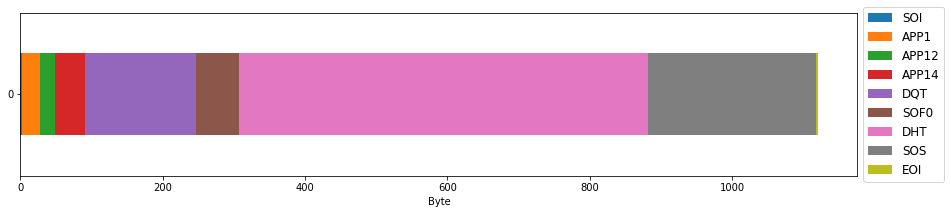

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_segment_lengths(fn=image_filename):
    file = open(fn, "rb")
    segments = [[],[]]
    s = 0
    for i in range(11):
        byte = (file.read(1), file.read(1))
        s+=2
        while hti(byte[0]+byte[1]) not in markers.keys():
            byte = (byte[1], file.read(1))
            s+=1
        segments[0].append(byte[0]+byte[1])
        if len(segments[0]) > 1 and len(segments[1]) > 0:
            segments[1].append(s-2-segments[1][-1])
        elif len(segments[0]) > 1:
            segments[1].append(s-2)
        if hti(byte[0]+byte[1]) == 65497:
            break
    segments[1].append(2)

    df = pd.DataFrame([segments[1]], columns=[markers[hti(x)] for x in segments[0]])
    df.plot.barh(stacked=True, figsize=(15, 3))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize="large")
    plt.xlabel("Byte")
    file.close()
visualize_segment_lengths()

This provides a nice high level view of our image. As previously mentioned, the first and last markers we see are the SOI and EOI, and they both take up a rather small number of bytes out of the total. The bulk of the information seems to be with in the **DQT**, **DHT**, and **SOS** segments. These are all crucial to generating the image, and will be worked on in later sections.
An interesting thing to note is the idea of metadata, information that is not image data, but rather is *about* image data. All of the segments with *APP* markers are metadata. This may contain information such as the device the image was taken on, the viewing angle of that device or the application that created the image (Photoshop, Paint, etc.). In this case, the image was created for use on the internet, which tends to cut out a lot of this unncessecary information. To see this metadata in action, let's recreate the same image in Photoshop and run the same visualization.

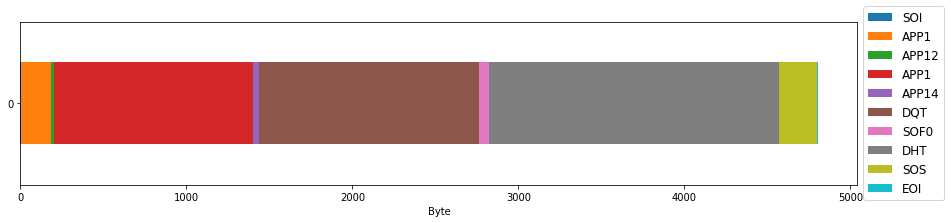

In [18]:
visualize_segment_lengths("images\\colors_metadata.jpg")

Clearly, this is a very different file structure. First off, the number of bytes between the SOI and EOI has increased nearly 5 fold. Before, there was a single APP1 segment, but now there are two. And perhaps most notibly, the APP1 segment takes up nearly as much data as the entire previous image! This goes to show that images seldom contain purely image data. These metadata segments can be interpreted as text to provide thousands of bytes of information regarding where this image came from. If you have ever wondered how it is possible that companies or the government can tell who took a picture, where, and at what time, it is likely because they are looking into one of these metadata segments. Thus, both to save space and preserve your privacy, it is quite easy and beneficial to use software, or write your own, that cuts out these segments, or does not generate them in the first place. This will be the last time we consider the *APP* segments, since they are not relavent to decoding.

## Section 2: Decoder Architecture

With an understanding of what it inside a JPEG file, we can move on to the strategy for decoding it. Unfortunately, there is a bit more work required that just reading each segment. The whole idea of an image format such as JPEG is to save space. Unlike a bitmap image, which, as the name suggests, directly maps a pixel in the image to a bit for its color, JPEG is a complex and efficient compression technique, storing the image in much less space than if you were to store each color at each position directly. Nonetheless, each step in this process is pretty simple, with the first being to look at each segment.

While parsing the segments, we will quickly acquire two important ones: **DHT** and **DQT**, which stand for Define Huffman Table and Define Quantization Table. The Huffman tables define a mapping between strings of bits we find in the image data and some value, while the quantization tables define a function we can use to convert data that is organized by frequency to data that is organized by its position in the image. We will discuss these both later on in more detail.

After parsing the segments and generating these two tables, we can use them to do entropy decoding, which is just using the Huffman tables to convert the raw image data. Afterwards, we use the Quantization tables to again convert the information. At this point, TODO: do the inverse cosine transform. Finally, since JPEG image data is stored under the YCbCr color space, we convert to RGB to get the final image.

<img src="images/2.1.jpg">


Next, we will begin to write functions that perform each of the steps in this diagram.

## Section 3: Parsing Segments: Part 1<a name="3"></a>

The general structure I will use to parse segments is defining a function for each of the segments we want to parse. These functions will take in the file we are reading as the argument `file`. An important Python function that will be repeatedly used is `read`. This function can read an entire file, or take in an integer representing the number of bytes to read and return from the given file object. So when we type `file.read(2)`, we read the next two bytes from the file and return that 2 byte value. Afterwards, I will always use my function previously defined, `hti`, to convert those bytes into an integer.

For all segments, the data of that segment starts immediately after the segment marker. So as soon as our program reads `0xFFC0`, the marker for SOFO, we can call the function to parse SOFO, and any subsequent calls to read will be reading the bytes that are next in the file.

On the surface, it is dangerous to assume that the byte pair read from a file corresponds to a particular tag. For instance, the various image data may contain `0xFFD8` but not intend to begin a SOI segment. The JPEG format uses two methods to differentiate between valid markers and markers that accidentally occur in the image data. These methods are using length values and byte stuffing, both of which will be discussed later.

### 3.1 - Start of Frame Parsing

As mentioned, the first segment we will write code to parse is the **start of frame** segment. According to the documentation, the first 2 bytes of a SOFO segment denote the length of the segment. That's easy enough to handle: we store that value into a variable called `length`. After that come the precision, height, width, and number of components. We store all of those in the same fashion.

While pieces of information like width and height are simple to read, since they are of fixed length, other data is a little trickier. The first variable length information we will see is the `components` data within the SOFO segment. This is a list of image components, each containing 3 bytes:
1. ID - Which part of the YCrCb color space this component holds
2. Sampling Factor - The level of sub-sampling to be used
3. Quantization Table - The ID of the quantization table to be used

This piece of information is variable length because there could be 1 component, or there could be 3, or some other value: we don't know for every image how many there will be. As such, we cannot hard-code calls to `read`. Instead, we will use the provided `length` value. Consider **Figure 3.1** below. The first yellow block denotes the 2 byte marker `0xFFC0`. All green blocks represent some piece of information we will read. The light green block is the block of variable length.
<img src="images/3.1.jpg">
The first value in the segment is the `length`, which is a 2 byte value, so it makes up bytes 3 and 4. Let's assume that after reading those 2 bytes, we saw `length=17`. Following the documentation, byte 5 will be the data precision, bytes 6 and 7 are the height, 8 and 9 are the width, and byte 10 is the number of components. Let's say the number of components read was `3`.

Since each component contains 3 bytes, we know that there will be `9` total bytes we need to read to get all 3 components. Furthermore, since the first 5 pieces of information took 8 bytes and the components took 9 bytes, that makes 17 bytes total. This matches the `length` value exactly.

With that understanding out of the way, we can look at the function itself. As mentioned, we take in a reference to the file. The function then reads all of the fixed length variables and stores them. It loops over the the number of components, adding them to an array. Finally, it returns a dictionary that maps the names of the values to the data we got from that segment.

In [19]:
def parse_SOF0(file):
    #length = 8 + (#components * 3)
    length = hti(file.read(2))
    #bits/sample
    precision = hti(file.read(1))
    height = hti(file.read(2))
    width = hti(file.read(2))
    #1 = grey scale, 3 = YCbCr, 4 = CMYK
    num_components = hti(file.read(1))
    components = []
    for i in range(int((length - 8) / 3)):
        #1 = Y, 2 = Cb, 3 = Cr, 4 = I, 5 = Q
        component_id = hti(file.read(1))
        sampling_factor = hti(file.read(1))
        q_table = hti(file.read(1))
        components.append({
            "id": component_id,
            "sampling_factor": sampling_factor,
            "q_table": q_table
        })
    return {
        "length": length,
        "precision": precision,
        "height": height,
        "width": width,
        "num_components": num_components,
        "components": components
    }

Notice that there is some further information we can extract from these values. Since the number of components describes the dimension of the color space that is used to display the image, it is clear that if there is only 1 value, we are parsing a purely gray-scale image. If there are 3 components, then we are dealing with the common YCbCr system: more on this later.

### 3.2 - Define Quantization Table Parsing

The next segment we will tackle is the **DQT** segment. This segment contains the values for a quantization table which will later be used for decoding image data. These tables are basically 8x8 matrices of integers. As with the SOFO segment, the first piece of information is a length value, which is again 2 bytes. After the length, there is a single information byte for the quantization table. This acts as an identifier, since there will be multiple tables. Last is the table itself, which contains `64` values if the precision is 0 (8 bit) and `128` values if the precision is 1 (16 bit). What's tricky here is that a segment may contain multiple quantization tables, each with a single information bit and a series of values. Thus, the only way to tell how many tables you have is to use the `length` value while parsing. Consider **Figure 3.2** below.
<img src="images/3.2.jpg">
The yellow block denotes the segment marker `0xFFDB`. After that, we can see the 2 byte length value, bytes 3 and 4. Let's assume that this value was `132`.
After the length, we enter a light green block, which contains a quantization table. We first read byte 5, the information byte of a table. Afterwards, we read the 64 values for that table, bytes 6 through 69.
At this point, from the tables alone we would not know if we had completed the segment. But since the total length was 132, and we had read 2 bytes for the length itself plus 65 bytes for the first table, there are `132 - 2 - 65 > 0` some number of bytes remaining. So we continue, assuming that there will be at least 1 more complete table to read. Again, reading 1 information bit, byte 70, and 64 values, bytes 71 through 134, giving us our second quantization table from this segment. At this point, `132` bytes have been read, so the segment is completed.

We can see the function implementing this logic below. The loop `while pos > 0` is what continues reading in information until the number of bytes read matches `length`. After reading in the 64 values, we convert them into an 8x8 numpy array.

In [20]:
import numpy as np

def parse_DQT(file):
    #length = 6+2(number of components)
    length = hti(file.read(2))
    tables = []
    pos = length-2
    
    while pos > 0:
        qt = hti(file.read(1))
        number = qt&0xF
        precision = qt >> 4
        table = {
            "id": number,
            "precision": precision
        }
        data = []
        for i in range(64*(precision+1)):
            data.append(hti(file.read(1)))
        matrix = reverse_zigzag(np.array(data).reshape(8,8))
        
        table["matrix"] = matrix
        tables.append(table)
        
        pos-=(1 + (64*(1+precision)))
        
    return {
        "length": length,
        "tables": tables
    }

You will notice that the 64 values are not being directly used after being shaped into an 8x8 matrix. They are first being passed into a function `reverse_zigzag` which has not yet been defined. The subtlety here is that the 64 values are not stored in order. Rather, they are stored in a format that best suits run length encoding. By sorting the values in a zigzag pattern starting from the top left rather than simply left to right, runs of 0s are easily encoded. This is helpful since there tend to be many 0s towards the bottom right of the quantization matrix. Thus, we must reverse this zig zag pattern using the function defined below.

In [21]:
def reverse_zigzag(m):
    pos = (0, 0) #row, col
    d = "up"
    r = np.zeros((len(m), len(m)))
    for n in m.flatten():
        r[pos[0], pos[1]] = n        
        if d == "up":
            if pos[0] == 0: #going up, hit the top
                d = "down"
                if pos[1] == len(m)-1: #hit the top/right corner
                    pos = (pos[0]+1, pos[1])
                else: #hit the top when going up
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == len(m)-1: #hit the right side when going up
                d = "down"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in middle
                pos = (pos[0]-1, pos[1]+1)
        else: #going down
            if pos[0] == len(m)-1: #hit the bottom
                d = "up"
                if pos[0] == 0: #hit the bottom/left corner
                    pos = (pos[0], pos[1]+1)
                else: #hit bottom
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == 0: #hit the left side
                d = "up"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in the middle
                pos = (pos[0]+1, pos[1]-1)
    return r

## Section 4: Huffman Encoding<a name="4"></a>

The next segment to parse is the **DHT** segment, but first, we must understand what a Huffman table is. Unlike quantization tables, a Huffman table is not simply a matrix of integers. Instead, Huffman encoding is a method of assigning binary codes to symbols. For instance, if we wanted to encode `abc`, we could assign `a -> 0`, `b -> 1`, and `c -> 11`. This issue with this would be that the code `11` could signify `bb` or `c`. One approach to fixing this is to use **fixed length encoding**, where each code has the same number of bits, so we know that they are not going to be split up into other symbols. This might look like `a -> 00`, `b -> 01`, and `c -> 10`. However, notice that the number of bits in each code increases dramatically as the number of symbols increases. Furthermore, if we use the symbol `a` 1000 times, and the symbol `q` only once, why should they take up the same amount of space in the encoding? The goal of JPEG is to compress data, and this would definitely waste space.

Huffman encoding instead uses **variable length encoding**, but solves that initial ambiguity issue by using **prefix free codes**. This means that no code is a prefix to another code, so whenever you see a code, you can be sure that no other code could build on top of it in later bits. We can envision this as a binary tree, with branches going left as `0` and right as `1`. The leaves of the tree are the symbols: nothing continues after the leaf, so all codes are prefix free. **Figure 4.1** shows the `abc` Huffman encoding from before.
<img src="images/4.1.jpg">
Another important aspect of this encoding method is frequency. Since we have variable length encoding, we should aim to have the *most frequent* symbols have the *smallest code length*, as this will be the most efficient use of space. We don't need to worry about the algorithm that gives the most frequent symbols shorter codes, since the DHT segment provides all of the information needed to construct the table. The two key pieces of information are the **code lengths** and the **symbols**.

Symbols are what we have already discussed: the value that the string of bits maps to. Instead of offering those bitstrings directly, which would be a large use of space for large tables, we are instead provided with the *number of codes* for each potential code length. The smallest code is of length `1`, and the largest is length `16`. So in the DHT segment, we are provided with an array of 16 values, each value telling us how many codes there are in the complete Huffman tree of that length. For example, the  array `[0, 0, 1, 1, 4, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]` means that we have 1 code of length 3, 1 of length 4, 4 of length 5, and so on. Note that after length 7, there are no code. To avoid processing codes that are not going to be there, I will later defined `last non-zero`, which is just the index of the last non-zero value in this array.

### 4.1 - Generating Bitstrings

With that understanding in place, let's assume that we have already parsed the segment into the argument `table`. Then, we will generate a list of bitstrings based on the length array `table["lengths"]`, which contains the number of codes in each of the 16 possible lengths. We can see that the outer most loop goes through every length from 1 to the last non-zero index, skipping all those that are 0 in-between. Throughout the entire function, we maintain a variable `value`. Throughout each length, we just add 1 to value, and pad the left side with zeros such that it matches the length for that iteration. Once we have completed all of the values for that length value, we shift value by 1 bit to the left. This increases the size of value, giving us an extra 0 bit to start generating new codes from. We cannot start over from 0 in generating the new codes since this would result in some overlapping prefixes. By adding 1 then shifting by 1 bit, the upper `n-1` bits correspond to no other code.

In [22]:
def generate_bitstrings(table):
    bitstrings = []
    value = 0
    for i in range(1,table["last non-zero"]+2):
        if table["lengths"][i-1] == 0:
            continue
        for code in range(table["lengths"][i-1]):
            bitstring = "{0:b}".format(value)
            bitstring = (i - len(bitstring))*"0" + bitstring
            bitstrings.append(bitstring)
            value+=1
        value <<= 1
    return bitstrings

Let's test if this function is working correctly by mocking a DHT `table` variable. We will make a random lengths array, and create a random symbols array to have a matching number of values. We should see a list printed of `7` 3 bit code corresponding to the first 7 symbols in the symbols array, then 1 code of length 4, 1 of length 5, and so on.

In [23]:
table = {
    "last non-zero": 8,
    "lengths": [0, 0, 7, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "symbols": [1, 2, 3, 4, 5, 6, 12, 11, 10, 9, 8, 7]
}

bitstrings = generate_bitstrings(table)
for pair in zip(bitstrings, table["symbols"]):
    print(pair)

('000', 1)
('001', 2)
('010', 3)
('011', 4)
('100', 5)
('101', 6)
('110', 12)
('1110', 11)
('11110', 10)
('111110', 9)
('1111110', 8)
('11111110', 7)


### 4.2 - Signed Values

One down side of this approach is that we have no direct ability to express negative values. Since we are using quantization tables and IDC tranform, negative values are a must. To express negatives, the symbols of a JPEG Huffman table are not meant to be directly expressed as image data values, but are the arguments to yet another table. For this conversion, we consider both the symbol and the length of the code. The length denotes how far from zero, in powers of 2, our new value will begin.

Let the absolute value of the lower bound be `2^(size-1)`. Thus, for `size = 3`, we can have values below `4` and above `-4`. The absolute value of the upper bound is then `2^(size)-1`. Again, for `size = 3`, we can have values below `7` and above `-7`. With this pattern, for any size, the number of possible positive values is `2^(size)-1 - 2^(size-1)`. From this, if we let the number of positive values be `X`, the total number of values, counting negatives, is `2X = Y`. The lower half of the potential code values are all negative, while the upper half are positive.
IMAGE

I define the function to compute the signed version based on a code and size below. Then, we test it for all codes of length `4` to see if the proper distribution is returned. For length `4`, the smallest negative should be `-(2^4-1) = -15`, and the largest negative should be `-2^(4-1) = -8`.

In [24]:
def signed_dc(dc, size):
    if size == 0:
        return 0
    lo = 2**(size-1)
    hi = lo*2-1
    mid = 2**size/2
    if dc < mid:
        d = mid - dc
        return int(-(lo + d - 1))
    else:
        d = dc - mid
        return int(lo + d)
    
for i in range(16):
    print(i, signed_dc(i, 4))

0 -15
1 -14
2 -13
3 -12
4 -11
5 -10
6 -9
7 -8
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15


The last piece of preparation for the Huffman segment is actually reading the table from the file. You'll notice that previously, we have been reading byte by byte, but the Huffman codes are not sectioned by byte, but rather byte bit. We need to read each `0` or `1` individually. Since Python's `read` function can only read bytes, we defined a custom function `read_bit`. Basically, we will read in a byte, but return a single bit of that byte each time the function is called, storing the remaining bits in `bit_buffer`. When the buffer is empty, we read in another byte to fill it with 8 new bits.

### 4.3 - Byte Stuffing

An important note is that the JPEG specification allows for markers to appear within the data that we will be reading. We know that markers preceeded by `0xFF` and then followed by some non-zero byte. But what if the image data actually contains `0xFFD8`, and does not intend to indicate a SOI marker? This is were **byte stuffing** is used. Instead of putting `0xFFD8` into the file to be confused with a marker, a zero byte is added, making it `0xFF00D8` instead. This no longer matches the pattern of a marker, so we know it is not. However, that zero byte did not represent image data, it was just inserted for formatting purposes, so we should not read it when we are working with our Huffman codes and such. 
<img src="images/4.3.jpg">
Thus, this read_bit function also makes sure that if it reads `0xFF00`, it consumes that `00` byte, and replaces it with the next byte. This makes it such that we can call `read_bit` and not worry about the byte stuffing later on.

In [25]:
bit_buffer = ""
prev_byte = None
def read_bit(file):
    global bit_buffer
    global prev_byte
    if bit_buffer == "":
        byte = file.read(1)
        if prev_byte == b'\xff' and byte == b'\x00':
            byte = file.read(1)
        prev_byte = byte
        bit_buffer = str(bin(hti(byte)))[2:]
        if len(bit_buffer) < 8:
            bit_buffer = "0"*(8 - len(bit_buffer)) + bit_buffer
    bit = int(bit_buffer[:1])
    bit_buffer = bit_buffer[1:]
    return bit

## Section 5: Parsing Segments Part 2<a name="5"></a>

### 5.1 - Define Huffman Table Parsing

With all that logic in place, we can read the DHT segment. The format of this segment follows the usual pattern, starting with a 2 byte length value. After that, there are some unknown number of Huffman tables. Each has an information bit, which we use to identify the table and describe it, followed by 16 values for the lengths list, and then the actual list of symbols.
After reading each table, we use the bitstring function generate the list of codes, and then create a map that connects each code to the symbol it represents.

In [26]:
def parse_DHT(file):
    length = hti(file.read(2))
    pos = length
    count = 0
    tables = []

    while pos > 0 and count < 4:
        count+=1
        ht_info = hti(file.read(1))
        pos-=1
        number = ht_info&0xF
        ht_type = ht_info >> 4
        
        table = {"id": number, "type": ht_type}
        
        lengths = []
        last = None
        for i in range(16):
            l = hti(file.read(1))
            lengths.append(l)
            if l != 0:
                last = i
        table["lengths"] = lengths
        table["last non-zero"] = last
        pos-=16
                
        symbols = []
        for i in range(16):
            if lengths[i] > 0:
                for j in range(lengths[i]):
                    symbols.append(hti(file.read(1)))
                    pos-=1
        table["symbols"] = symbols
        tables.append(table)
        
    maps = {}
    for table in tables:
        if table["id"] not in maps.keys():
            maps[table["id"]] = {}
        maps[table["id"]]["DC" if table["type"]==0 else "AC"] = dict(zip(generate_bitstrings(table), table["symbols"]))

    return { "length": length, "tables": tables, "maps": maps }

### 5.2 - Start of Scan Parsing

This final segment is relatively simple. We first read in the usual 2 byte length. Then, we read in the number of components. These roughly correspond to the channels of the image. For each channel, we read in 2 bytes. The first corresponds to the id of that component, and the second byte uses the upper 4 bits to denote which Huffman table we should use for the DC values, and the lower 4 bits to denote with Huffman table we should use for the AC values. After getting this information for each component, the specification says we must read and throw away `3` bits. This is presumably so that the next data starts on an even byte boundary. Immediately after the SOS segment is the scan data, the section where all of the image information is actually stored, and our Huffman tables will begin to be useful.

In [27]:
def parse_SOS(file):
    #length = 6+2*(number of components)
    length = hti(file.read(2))
    number_components = hti(file.read(1))
    components = []
    for i in range(number_components):
        cid = hti(file.read(1))
        table = hti(file.read(1))
        components.append({
            "id": cid,
            "AC": table&0xF,
            "DC": table>>4
        })
    file.read(3)
    
    return {
        "length": length,
        "number of components": number_components,
        "components": components
    }    

## Section 6: Scan Data<a name="6"></a>

All of the pieces necessary to extract meaningful data from the scan segment has been prepared. Scan data is sectioned into MCUs, or minimal coded units. These are 8 pixel by 8 pixel squares which are later converted into 8x8 sections from the image. Since images have multiple color channels, the MCUs for these channels are listed in sequential order. For instance, if the image uses the YCbCr color space, the first MCU would correspond to the Y channel, the second Cb, and the third Cr.

Each MCU is made up of 64 values, 1 DC value and 63 AC values. The DC value is the average of the entire MCU, and thus defines the general hue of that section of the image. The DC value is relative to the DC of the previous MCU's DC value, with the value before the first being 0.
Explain DC vs AC. For the DC value, we read bits until we find a corresponding Huffman code. Then, this value represents the number of bits to read further. For instance, if the Huffman table maps to a value of `6`, we read in 6 more bits to get the DC value, which is then converted to a signed value. For the AC components, they can be read directly from the Huffman table and then converted to signed values. When reading AC values, if the Huffman table ever maps to 0, this indicated an *End Of Block*, meaning we can assume the remaining values are all 0, and the next MCU can be read.

### 6.1 - ZRL

There is one last special case the occurs in the scan data. Sometimes, there are long stretches of 0s. This can be easily encoded using *Run Length Encoding*, where we specify the number of values that are all the same. In the case of JPEG, this is called *ZRL*, or zero run length. It represents the number of zero coefficients before the next non-zero value. This is an easy means of compressing the coefficients in the DCT matrix, sinc eit is common to have lots of zeros in some areas, which indicates high frequency coefficients.

The strategy is then to read bits until there is a match in the Huffman table. Then, the upper 8 bits are the ZRL, and the lower 8 bits are the unsigned coefficient value.

0x13 is "1 zero leading 3 bit number"

Example 1: `01 01 0100`. The table matches `01` as 02, so you read 2 more bits: `01`. Thus, the value is 1 for size 2, which maps to -1. No zero run length byte.

Example 2: `1010 0`. `1010` matches `0x11`. this means 1 zero and a leading bit of 1. for the signed lookup, this is size=1 and value=0 which returns -1. [-1]

Example 3: `11111000 10`. `11111000` matches `0x22`. zrl = 2, bit length = 2. value = 2. signed value = . [2]


Example 4: `11100 01`. `11100` matches `0x12`. zrl=1, length = 2. value = 1, signed value = -2. [-2]

### 6.2 - Reading Image Data

Finally, we write the function `read_image_data`. This will loop over the number of MCUs we have in the image, which is calculated based on the size of the image from the SOF0 segment and dividing by 8 in both dimensions. For each MCU, we loop through the number of components. Then in each MCU, we read a single DC value, then 63 AC values to populate an 8x8 matrix for the DCT. The function then returns an array of all of these DCTs.

In [28]:
def read_image_data(file):
    mcus = []
    #loop over all MCUs
    #potentially make this a while(true), and then break when not enough information is found
    for current_mcu in range(1):
        #loop over the color components for each mcu
        mcu = []
        for component in data["SOS"][0]["components"]:
            print("MCU {}, component {}".format(current_mcu, component))
            dc_map = data["DHT"][0]["maps"][component["DC"]]["DC"]
            ac_map = data["DHT"][0]["maps"][component["AC"]]["AC"]

            #number of bits for DC value
            bit_string = str(read_bit(file))
            while bit_string not in dc_map:
                bit_string += str(read_bit(file))
            bits = dc_map[bit_string]
            
            #1 DC value
            bit_string = ""
            for i in range(bits):
                bit_string+=str(read_bit(file))
            
            if bit_string == "":
                bit_string = "0"
            
            dc = signed_dc(int(bit_string, 2), bits)
            dct = [dc]

            #63 AC values
            while len(dct) < 64:
                
                #get length for next AC value
                bit_string = str(read_bit(file))
                while bit_string not in ac_map:
                    bit_string += str(read_bit(file))
                bits = ac_map[bit_string]
                
                zrl = bits >> 4;
                bits = bits & 0xF
                
                #0 code corresponds to EOB, end of block.
                if bits == 0:
                    break
                    
                #get the bits for the ac value
                bit_string = ""
                for i in range(bits):
                    bit_string+=str(read_bit(file))
                    
                #convert to signed ac value
                ac = signed_dc(int(bit_string, 2), bits)
                
                if zrl > 0:
                    #print("i={} bits={}, ac={}, zrl={}".format(i, bits, ac, zrl))
                    for _ in range(zrl):
                        dct.append(0)
                
                dct.append(ac)
                                
                bit_string = ""

            #fill in remaining spots with 0
            if len(dct) < 64:
                dct = dct + (64-len(dct))*[0]
                
            dct = np.array(dct)
            dct = dct.reshape(8,8)
            mcu.append(dct)
            
        mcus.append(mcu)
        
    return mcus

We can now use the all of the functions we have written on the actual image. First, we create the function `next_segment`, which will read byte by byte until a segment is found. We then create a dict `data`, which will be a simple way to dump the information we parse from the important segments. The main loop will loop through the image, calling each of our segment parsing functions when those segments are detected. Once the SOS segment is found and parsed, we call `read_image_data` to do reading of the scan data. We assign the output of the function to `mcus`, which will be used later to process the image.

In [29]:
def next_segment(file):    
    b1 = file.read(1)
    b2 = file.read(1)
    while hti(b1+b2) not in markers.keys():
        b1 = b2
        b2 = file.read(1)
    m = hti(b1+b2)
    return markers[m]

file = open(image_filename, "rb")
data = {
    "SOF0": [],
    "DHT": [],
    "DQT": [],
    "SOS": []
}

while True:
    segment = next_segment(file)
    if segment == "SOF0":
        data[segment].append(parse_SOF0(file))
    elif segment == "DHT":
        data[segment].append(parse_DHT(file))
    elif segment == "DQT":
        data[segment].append(parse_DQT(file))
    elif segment == "SOS":
        data[segment].append(parse_SOS(file))
        mcus = read_image_data(file)
        break
file.close()

MCU 0, component {'id': 1, 'AC': 0, 'DC': 0}
MCU 0, component {'id': 2, 'AC': 1, 'DC': 1}
MCU 0, component {'id': 3, 'AC': 1, 'DC': 1}


### 6.3 - Building MCUs

Since we have to process each MCU in the same way, it makes sense to wrap that logic up in a function. Referring to the flow chart in Figure 2.1, each MCU must first go through quantization, where we do an element-wise multiplication with the DCT matrix and its corresponding Quantization table. Afterwards, we perform an Inverse Discrete Cosine Transform, using the `idctn` function from SciPy. We then round all of the values to get even integers. Afterwards, we center the values back to their normal ranges by adding 128, and finally clip the values to the range `[0, 255]`, just in case any of the math produced values outside a valid color range.

In [30]:
from scipy.fftpack import idctn
def build_mcu(dct, qt):
    q = data["DQT"][0]["tables"][qt]["matrix"]
    m = np.multiply(dct, q)
    m = idctn(m, norm="ortho")
    m = np.round(m)
    m += 128
    m = m.clip(0, 255)
    return m

After building the corrected MCUs, we will convert them from the YCbCr color space to simple RGB. This is simply done by applying a formula.

In [31]:
def ycbcr_to_rgb(c):
    y, cb, cr = c
    r = y+1.402*(cr-128)
    g = y-0.344136*(cb-128)-0.714136*(cr-128)
    b = y+1.772*(cb-128)
    return r, g, b

At last, we can display the results of our efforts. Looping over the MCUs, just one in this case, and the looping over each of the color channels, we can generate the image.

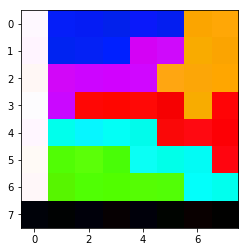

In [32]:
img = []
for mcu in mcus:
    qt = 0
    c = []
    for channel in mcu:
        corrected = reverse_zigzag(channel)
        corrected = build_mcu(corrected, qt)
        c.append(corrected)
        qt = 1
    z = np.array([a for a in zip(c[0].flatten(), c[1].flatten(), c[2].flatten())])
    k = [ycbcr_to_rgb(a) for a in z]
    k = np.array(k).reshape(8, 8, 3) / 255
    z = np.array(z).reshape(8, 8, 3) / 255
    if len(img) == 0:
        img = k
        img_ycbcr = z
    else:
        img = np.concatenate((img, k), axis=1)
    img = img.clip(0, 1)
    image = img
plt.imshow(img)

### 6.4 - Evaluation

This decoding may seem accurate, but it is important to consider exactly how accurate. JPEG encoding is a lossy process, meaning the use of discrete cosine transforms does not allow the image to be rebuilt exactly as it was encoded. We can use a standard library such as PIL to automatically generate the RGB information for comparison, assuming the library does the decoding correctly. We can then take the difference between each red, green, and blue value for each pixel, sum up the differences, and divide by the total number of pixels/channel to get the average error per pixel per color channel. The range for this error is `[0, 255]`, with `0` indicating a perfect match and `255` indicating that the correct image was all black and our decoding was all white.

After getting the average error, we can plot the difference in pixel values as a new image, to see which pixels were more incorrect than others, with brighter pixels indicating a higher error.

Average Error Per Pixel = 0.049021541666666724


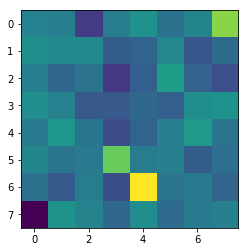

In [33]:
from PIL import Image
i = Image.open(image_filename, 'r')
data = i.getdata()
rgb = np.array(list(data)).reshape(8, 8, 3)
diff = rgb - (image*255)
avg_error = abs(diff.sum() / (8*8*3))
print("Average Error Per Pixel = {}".format(avg_error))
diff = diff.reshape(64, 3)
diff = np.array([x.sum() for x in diff]).reshape(8, 8)
plt.imshow(diff)

With this average error, we can see the decoding was very accurate, and the process is complete.

## Section 7: Notes<a name="7"></a>
- The MCU building code assumes that the YCbCr color space is used, but others are also possible.
- There are different sub-sampling ratios that may occur, but were not seen in the sample image.
- In this case, the image was an even 8x8 pixels. If the image does not fit an integer number of MCUs, the pixels on the edges will just be black and then are cut off when displaying the image, since the true size is specified.